# Shifterator

We load the articles and create two dictionaries where keys are word types and values are their frequencies for each media ideology.

In [1]:
# import modules
import pandas as pd
import shifterator as sh
from nltk import text
import numpy as np

In [2]:
df = pd.read_csv('preprocessed.csv', encoding='latin-1')
df.head()  

,date,maintext,title,source,media_name,ideology,Congress,text
0,2015/02/13,Advertisement\r\r\nIn honor of our 95 annivers...,6 Ways the League of Women Voters Has Impacted...,http://www.huffingtonpost.com/elisabeth-macnam...,Huffington Post,left,114th,"honor 95 anniversary, list things americans pa..."
1,2015/02/10,"As state legislatures shift into high gear, ma...",Opportunities for Effective Election Reforms C...,http://www.huffingtonpost.com/robert-m-brandon...,Huffington Post,left,114th,"state legislatures shift high gear, election r..."
2,2015/02/22,"FILE - In a Tuesday, Nov. 4, 2014 file photo, ...","Scott Walker Pushes ALEC 'Right to Work' Bill,...",http://www.huffingtonpost.com/mary-bottari/sco...,Huffington Post,left,114th,"file - tuesday, nov. 4, 2014 file photo, wisco..."
3,2015/02/25,Former Ohio Gov. Ted Strickland (D) announced ...,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,Huffington Post,left,114th,ohio gov. ted strickland (d) announced wednesd...
4,2015/02/26,Nevada Senate Minority Leader Michael Roberson...,Nevada GOP Pushes New Gun Law Reminiscent Of '...,http://www.huffingtonpost.com/2015/02/26/nevad...,Huffington Post,left,114th,nevada senate minority leader michael roberson...


In [8]:
import nltk
def preprocessing(corpus):
    # initialize
    clean_text = []

    for row in corpus:
        #word tokenize
        tokens = nltk.tokenize.word_tokenize(row)
         #lowercase
        tokens = [token.lower() for token in tokens]
        # isword
        tokens = [token for token in tokens if token.isalpha()]
        clean_sentence = ''
        clean_sentence = ' '.join(token for token in tokens)
        clean_text.append(clean_sentence)
        
    return clean_text

In [9]:
df['cleantext'] = preprocessing(df.astype(str)['maintext'])

In [11]:
#define stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
#remove stopwords
df['cleantext'] = df['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [12]:
# creating two different datasets for media split by ideology
ideology = df.groupby("ideology")
left = ideology.get_group('left')
right = ideology.get_group('right')

In [13]:
left_text =left['cleantext'].apply(str) # left leaning media
right_text= right['cleantext'].apply(str) # right leaning media

In [14]:
tokens_left = [" ".join(strings.split()) for strings in left_text] 
string_left = " ".join(tokens_left)

tokens_right = [" ".join(strings.split()) for strings in right_text] 
string_right = " ".join(tokens_right)

In [15]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [16]:
left_dic = word_count(string_left)
right_dic = word_count(string_right)

### Frequency-Based Shifts
Many word shifts can be constructed using only the frequency counts of how often words appear in each of two texts. The frequencies should be loaded into two dictionaries type2freq_1 and type2freq_2, where keys are word types and values indicate how many times that word appeared in that text.



/opt/conda/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


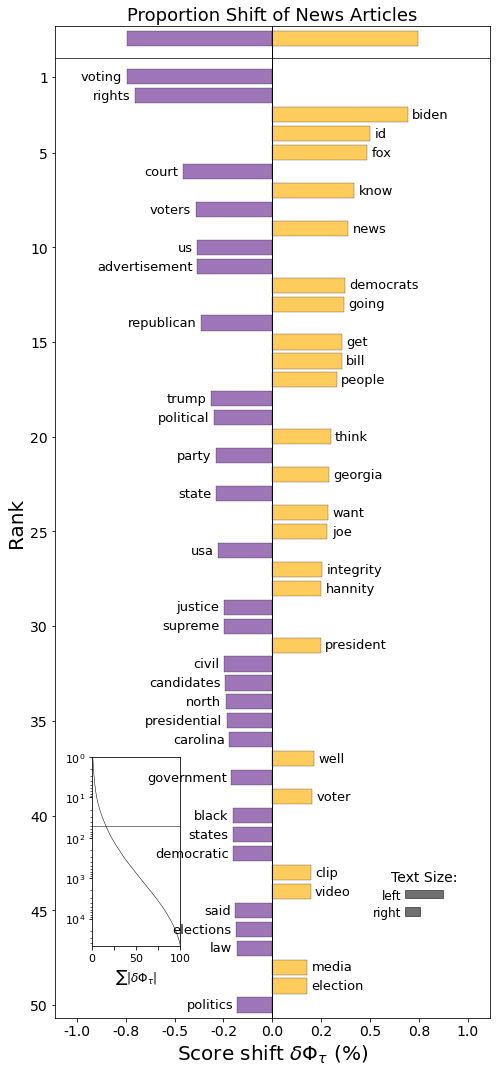

<AxesSubplot:title={'center':'Proportion Shift of News Articles'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [31]:
proportion_shift = sh.ProportionShift(type2freq_1=left_dic, type2freq_2=right_dic)
proportion_shift.get_shift_graph(system_names = ['left', 'right'], top_n=50, title='Proportion Shift of News Articles')

### Shannon entropy word shift

Proportion shifts are easy to interpret, but they are simplistic and have a difficult time pulling out interesting differences between two texts. For example, we see many “stop words” in the proportion shift. Instead, we can use the Shannon entropy to identify more “surprising” words and how they vary between two texts. The less often a word appears in a text, the more surprising that it is. The Shannon entropy can be interpreted as the average surprisal of a text. We can compare two texts by taking the difference between their entropies. We can rank these contributions and plot them as a Shannon entropy word shift. If the contribution is positive, then the word has a higher score in the second text. If the contribution is negative, then its score is higher in the first text.

/opt/conda/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


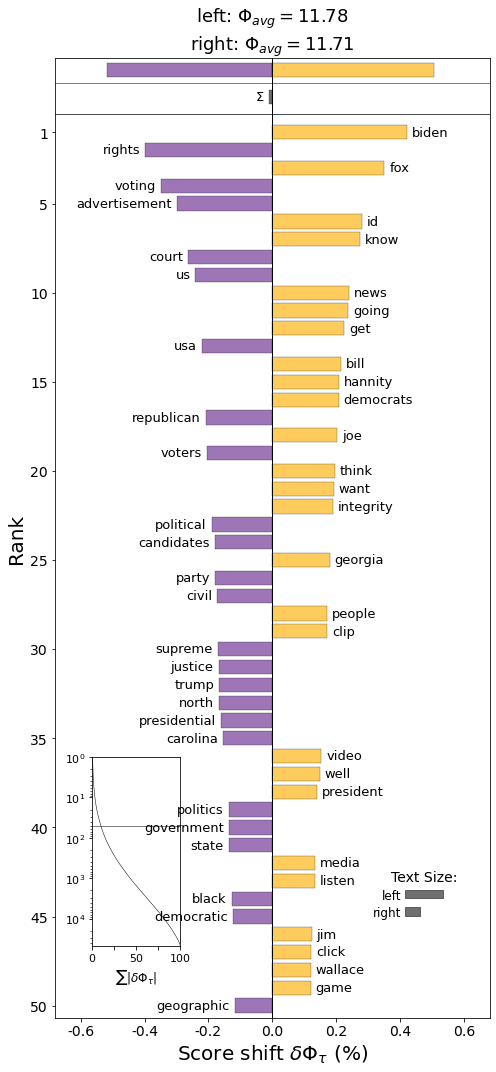

<AxesSubplot:title={'center':'left: $\\Phi_{avg}=$11.78\nright: $\\Phi_{avg}=$11.71'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [67]:
entropy_shift = sh.EntropyShift(type2freq_1=left_dic,
                                type2freq_2=right_dic,
                                base=2)
shift = entropy_shift.get_shift_graph(system_names = ['left', 'right'], top_n=50)
shift

In [22]:
test_dict=entropy_shift.get_shift_scores()

In [24]:
df2 = pd.DataFrame.from_dict({'score': list(test_dict.values()), 'word': list(test.keys())})
df2

,score,word
0,0.000010,lamenting
1,0.000002,evacuate
2,0.000005,ammons
3,0.000013,shagwell
4,-0.000004,kearse
...,...,...
47255,0.000014,squash
47256,0.000003,subhead
47257,-0.000059,courthouse
47258,0.000009,washes


In [25]:
df2['left_right'] = np.where(df2['score']<0, 'left', 'right')

In [26]:
df2

,score,word,left_right
0,0.000010,lamenting,right
1,0.000002,evacuate,right
2,0.000005,ammons,right
3,0.000013,shagwell,right
4,-0.000004,kearse,left
...,...,...,...
47255,0.000014,squash,right
47256,0.000003,subhead,right
47257,-0.000059,courthouse,left
47258,0.000009,washes,right


## Named entities with spacy

In [55]:
import spacy
from collections import Counter
nlp = en_core_web_sm.load()
# for visualizations
%matplotlib inline

In [76]:
tokens2 = tokens.retokenize

In [58]:
items = [x.text for x in tokens.ents]
Counter(items).most_common(50)

[('Democrats', 307),
 ('GOP', 180),
 ('Republicans', 179),
 ('Georgia', 161),
 ('Texas', 157),
 ('Biden', 131),
 ('Trump', 125),
 ('North Carolina', 110),
 ('Senate', 87),
 ('Wisconsin', 65),
 ('Republican', 52),
 ('Dems', 47),
 ("'USA TODAY'", 46),
 ('2020', 46),
 ('Americans', 45),
 ('MLB', 42),
 ('Supreme Court', 39),
 ('Democrat', 39),
 ('Stacey Abrams', 39),
 ('Democratic', 35),
 ('Florida', 35),
 ('America', 34),
 ('US', 32),
 ('Kansas', 28),
 ('House', 27),
 ('Virginia', 26),
 ('2016', 24),
 ("'Supreme Court", 24),
 ('Donald Trump', 23),
 ('Pennsylvania', 22),
 ('Iowa', 22),
 ('Arkansas', 21),
 ('John Lewis', 21),
 ('American', 21),
 ('Joe Biden', 21),
 ('Hillary Clinton', 19),
 ('U.S.', 19),
 ('Editorial Roundup', 19),
 ('CNN', 18),
 ('Arizona', 18),
 ('Congress', 16),
 ('2022', 16),
 ('Alabama', 15),
 ('November', 15),
 ('Atlanta', 15),
 ('RNC', 14),
 ('Jim Crow', 14),
 ('All-Star Game', 14),
 ('Tim Scott', 13),
 ('One', 13)]

In [53]:
#extract named entities

person_list = []
for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])

In [60]:
#still need to merge the ones that refer to the same 
df_person

,text,count
0,Biden,130
1,Stacey Abrams,38
2,Trump,25
3,Donald Trump,23
4,John Lewis,21
5,Joe Biden,21
6,Hillary Clinton,19
7,Editorial Roundup,19
8,Tim Scott,13
9,Mitch McConnell,13


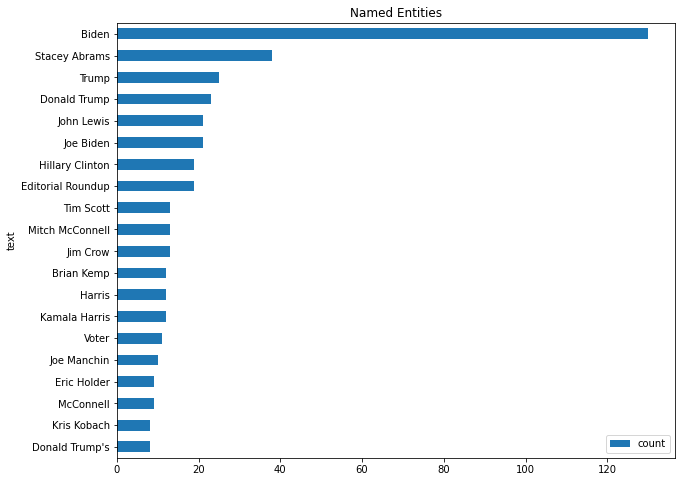

In [59]:
df_person.plot.barh(x='text', y='count', title="Named Entities", figsize=(10,8)).invert_yaxis()

In [68]:
#recognize polgroups and nationalities
norp_list = []
for ent in tokens.ents:
    if ent.label_ == 'NORP':
        norp_list.append(ent.text)
        
norp_counts = Counter(norp_list).most_common(10)
df_norp = pd.DataFrame(norp_counts, columns =['text', 'count'])

In [69]:
#still need to merge the ones that refer to the same 
df_norp

,text,count
0,Democrats,307
1,Republicans,179
2,Republican,52
3,Dems,47
4,Americans,45
5,Democrat,39
6,Democratic,35
7,American,20
8,Native Americans,9
9,Native American,8


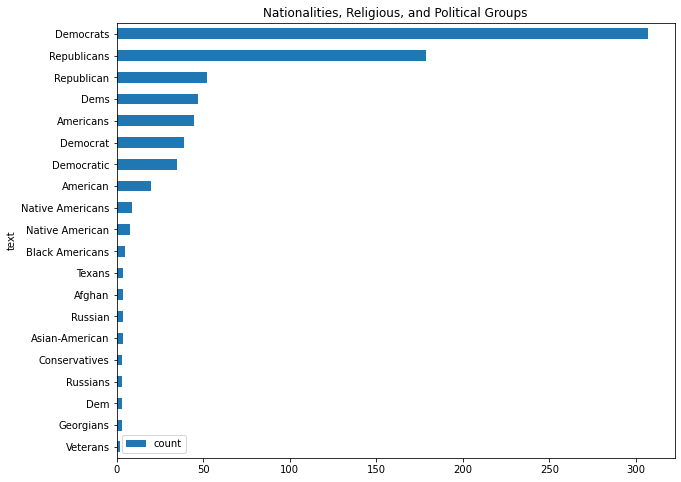

In [51]:
#still need to merge the ones that refer to the same 
df_norp.plot.barh(x='text', y='count', title="Nationalities, Religious, and Political Groups", figsize=(10,8)).invert_yaxis()